# `fsspec-reference-maker` tutorial

Created June 8th, 2020 by [Lucas Sterzinger](mailto:lsterzinger@ucdavis.edu) ([Twitter](https://twitter.com/lucassterzinger)) as part of the NCAR [Summer Internship in Parallel Computational Science (SIParCS)](https://www2.cisl.ucar.edu/siparcs)

If any part of this tutorial is now out of date, please feel free to open a pull request with a fix

### First, install and import fsspec_reference_maker

In [3]:
!pip install --user git+https://github.com/intake/fsspec-reference-maker@84c15d98a1e0ca04469f2453028b936b124e7df

  Cloning https://github.com/intake/fsspec-reference-maker (to revision 84c15d98a1e0ca04469f2453028b936b124e7df) to /tmp/pip-req-build-fcq143jd
  Running command git clone -q https://github.com/intake/fsspec-reference-maker /tmp/pip-req-build-fcq143jd
  Running command git checkout -q 84c15d98a1e0ca04469f2453028b936b124e7df


### Update s3fs and fsspec to latest versions

In [2]:
!pip install --upgrade --user s3fs fsspec

  Using cached s3fs-2021.6.0-py3-none-any.whl (24 kB)
  Using cached s3fs-2021.5.0-py3-none-any.whl (24 kB)
  Using cached fsspec-2021.6.0-py3-none-any.whl (114 kB)
  Using cached fsspec-2021.5.0-py3-none-any.whl (111 kB)


In [4]:
import fsspec_reference_maker.hdf as fsshdf

_Note: If the import still fails after installing with pip, restart the kernel by selecting Kernel ->  Restart Kernel from the Jupyter Notebook menu bar_

In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import datetime as dt

import logging
import fsspec
import json
from tqdm import tqdm
from glob import glob

In [6]:
import fsspec_reference_maker.hdf as fsshdf

## Create metadata JSONs

### This function returns a list of S3 files for a given satellite, year, and day

In [7]:
def get_file_list(sat,lyr,idyjl):
    # arguments
    # sat   goes-east,goes-west,himawari
    # lyr   year
    # idyjl day of year
    
    d = dt.datetime(lyr,1,1) + dt.timedelta(days=idyjl)
    fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!

    #create strings for the year and julian day
    imon,idym=d.month,d.day
    syr,sjdy,smon,sdym = str(lyr).zfill(4),str(idyjl).zfill(3),str(imon).zfill(2),str(idym).zfill(2)
    
    #use glob to list all the files in the directory
    if sat=='goes-east':
        file_location,var = fs.glob('s3://noaa-goes16/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='goes-west':
        file_location,var = fs.glob('s3://noaa-goes17/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='himawari':
        file_location,var = fs.glob('s3://noaa-himawari8/AHI-L2-FLDK-SST/'+syr+'/'+smon+'/'+sdym+'/*/*L2P*.nc'),'sea_surface_temperature'
    
    return file_location

In [8]:
flist = get_file_list("goes-east", 2020, 210)
urls = ["s3://" + f for f in flist]

### This function creates JSON metadata files for each of the S3 files in the local `jsons/` directory

These files point to the S3 location of the netCDF files, and only need to be created once. Tihs process took me about 10 minutes to generate the JSONs for 24 files. This function could easily be made to run in parallel for faster performance

In [9]:
def gen_json(urllist):
    so = dict(
        mode="rb", anon=True, default_fill_cache=False, default_cache_type="none"
    )

    for u in tqdm(urllist):
        with fsspec.open(u, **so) as f:
            h5chunks = fsshdf.SingleHdf5ToZarr(f, u, xarray=True)
            j = h5chunks.translate()
            fname = u.split("/")[7]
            with open(f"./jsons/{fname}.json", "w") as fout:
                fout.write(json.dumps(j))


In [10]:
gen_json(urls)

100%|██████████| 24/24 [09:33<00:00, 23.88s/it]


***
## Read remote netCDF files with xarray and fsspec

### First, create a list of JSON files

In [11]:
json_list = sorted(glob("./jsons/*.json"))

### Then, loop over the files and use `fsspec.get_mapper()` to create mappers for each file object, creating a list of mappers

In [12]:
m_list = []
for js in tqdm(json_list):
    with open(js) as f:
        m_list.append(fsspec.get_mapper("reference://", fo=json.load(f), remote_protocol="s3", remote_options={"anon": True}))


100%|██████████| 24/24 [00:09<00:00,  2.66it/s]


### Now, the mapper list can be passed directly to `xarray.open_mfdataset()` as long as the engine is specified as "zarr"

In [13]:
ds = xr.open_mfdataset(m_list, combine='nested', concat_dim='t',
                       engine='zarr', coords='minimal', 
                       data_vars='minimal', compat='override')

### Take a subset of the data (in this case, the Gulf Stream)

### Select a single time with `.isel(t=14)`

CPU times: user 379 ms, sys: 39.5 ms, total: 418 ms
Wall time: 3.09 s


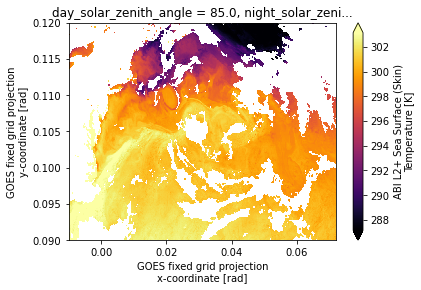

In [19]:
%%time
subset = ds.sel(x=slice(-0.01,0.07215601),y=slice(0.12,0.09))  #reduce to GS region

masked = subset.SST.where(subset.DQF==0)

masked.isel(t=14).plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')

### Plot a mean along the time axis (1-day average)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 4.71 s, sys: 406 ms, total: 5.12 s
Wall time: 28.9 s


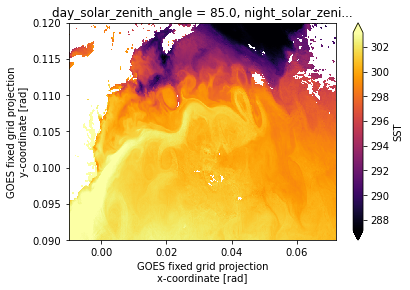

In [18]:
%%time
subset = ds.sel(x=slice(-0.01,0.07215601),y=slice(0.12,0.09))  #reduce to GS region

masked = subset.SST.where(subset.DQF==0)

masked.mean("t", skipna=True).plot(vmin=14+273.15,vmax=30+273.15,cmap='inferno')